2025-03-16 21:36:51,626 - INFO - Scanning dataset for potential LLM training datasets...
2025-03-16 21:37:18,077 - INFO - Found 10 usable files for LLM training
2025-03-16 21:37:18,107 - INFO - Similarity matrix built successfully



Corpus Statistics:
Total files: 10
Total tokens: 139,896
Average quality score: 8.22/10


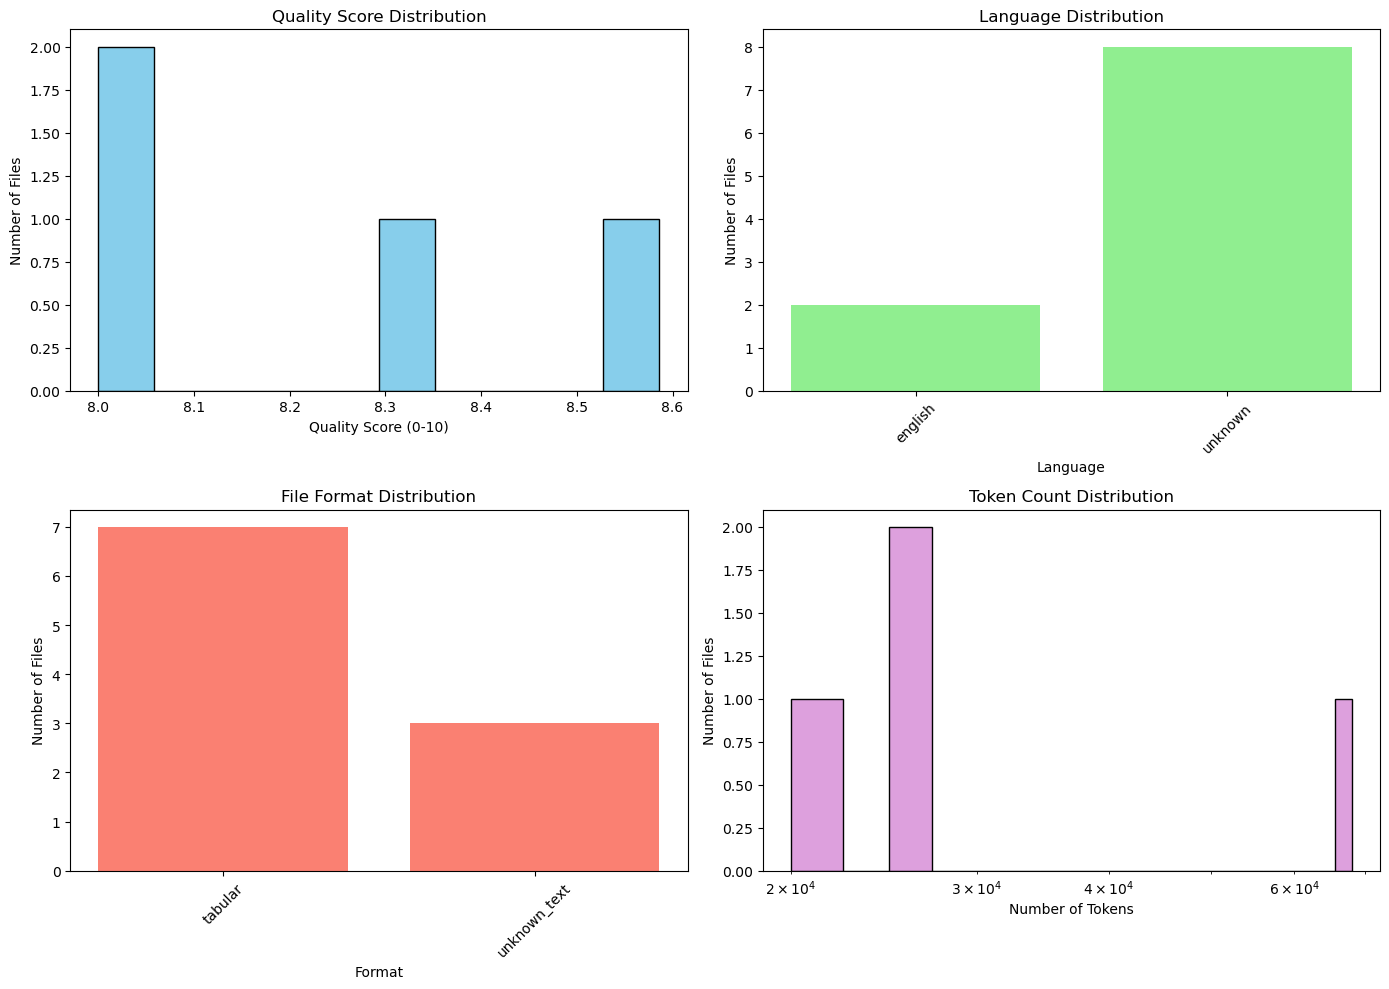


Recommended Training Mix:
Selected 4 files


TypeError: unsupported format string passed to sage.rings.rational.Rational.__format__

In [ ]:
import os
import numpy as np
import pandas as pd
import json
import csv
import pickle
import random
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
import hashlib
from concurrent.futures import ThreadPoolExecutor
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class LLMTrainingRecommender:
    def __init__(self, dataset_dir="dataset", sample_size=5000, min_token_freq=5):
        self.dataset_dir = dataset_dir
        self.file_info = []
        self.vectorizer = TfidfVectorizer(stop_words='english')
        self.similarity_matrix = None
        self.sample_size = sample_size
        self.min_token_freq = min_token_freq
        self.corpus_stats = {}
        self.token_frequency = Counter()
        self.file_quality_scores = {}
        
    def scan_datasets(self, max_workers=4):
        """Scan the dataset directory and collect information about all files."""
        logging.info(f"Scanning {self.dataset_dir} for potential LLM training datasets...")
        
        all_files = []
        for root, _, files in os.walk(self.dataset_dir):
            for file in files:
                file_path = os.path.join(root, file)
                all_files.append(file_path)
        
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            results = list(executor.map(self._process_file, all_files))
            
        # Filter out None results (files that couldn't be processed)
        self.file_info = [result for result in results if result is not None]
        
        logging.info(f"Found {len(self.file_info)} usable files for LLM training")
        return self.file_info
    
    def _process_file(self, file_path):
        """Process a single file and extract its information."""
        try:
            file_extension = os.path.splitext(file_path)[1].lower()
            file_name = os.path.basename(file_path)
            file_size = os.path.getsize(file_path)
            
            # Only process text-based files that can be used for LLM training
            if file_extension not in ['.txt', '.csv', '.json', '.dat', '.jsonl']:
                return None
                
            # Extract metadata based on file type
            metadata = self._extract_metadata(file_path, file_extension)
            
            # Compute MD5 hash for duplicate detection
            file_hash = self._compute_file_hash(file_path)
            
            return {
                'path': file_path,
                'name': file_name,
                'extension': file_extension,
                'size': file_size,
                'hash': file_hash,
                'metadata': metadata
            }
        except Exception as e:
            logging.warning(f"Error processing file {file_path}: {str(e)}")
            return None
    
    def _extract_metadata(self, file_path, extension):
        """Extract metadata relevant to LLM training from files."""
        metadata = {
            'row_count': None,
            'token_count': None,
            'avg_length': None,
            'language': 'unknown',
            'quality_score': None,
            'content_sample': "",
            'data_format': None,
            'vocabulary_richness': None
        }
        
        try:
            text_sample = ""
            
            if extension == '.txt':
                with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                    lines = f.readlines()
                    metadata['row_count'] = len(lines)
                    
                    # Get a sample of the text for analysis
                    sample_size = min(self.sample_size, len(lines))
                    sample_indices = random.sample(range(len(lines)), sample_size) if len(lines) > sample_size else range(len(lines))
                    text_sample = "".join([lines[i] for i in sample_indices])
                    metadata['data_format'] = 'plain_text'
                    
            elif extension == '.csv':
                with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                    csv_reader = csv.reader(f)
                    headers = next(csv_reader, [])
                    rows = list(csv_reader)
                    metadata['row_count'] = len(rows)
                    metadata['data_format'] = 'tabular'
                    
                    # Look for text columns that could be used for training
                    text_columns = []
                    for i, header in enumerate(headers):
                        if header.lower() in ['text', 'content', 'description', 'prompt', 'response', 'message']:
                            text_columns.append(i)
                    
                    # Get a sample of text from identified columns
                    if text_columns:
                        sample_size = min(self.sample_size, len(rows))
                        sample_indices = random.sample(range(len(rows)), sample_size) if len(rows) > sample_size else range(len(rows))
                        for idx in sample_indices:
                            for col in text_columns:
                                if col < len(rows[idx]):
                                    text_sample += rows[idx][col] + " "
                    
            elif extension in ['.json', '.jsonl']:
                is_jsonl = extension == '.jsonl'
                text_fields = []
                
                if is_jsonl:
                    # For JSONL, read line by line
                    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                        lines = f.readlines()
                        metadata['row_count'] = len(lines)
                        
                        # Sample lines
                        sample_size = min(self.sample_size, len(lines))
                        sample_indices = random.sample(range(len(lines)), sample_size) if len(lines) > sample_size else range(len(lines))
                        
                        for idx in sample_indices:
                            try:
                                obj = json.loads(lines[idx])
                                # Extract text fields recursively
                                self._extract_text_fields(obj, "", text_fields)
                            except:
                                pass
                else:
                    # Regular JSON
                    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                        data = json.load(f)
                        if isinstance(data, list):
                            metadata['row_count'] = len(data)
                            # Sample entries
                            sample_size = min(self.sample_size, len(data))
                            sample_indices = random.sample(range(len(data)), sample_size) if len(data) > sample_size else range(len(data))
                            
                            for idx in sample_indices:
                                self._extract_text_fields(data[idx], "", text_fields)
                        else:
                            # Single object
                            metadata['row_count'] = 1
                            self._extract_text_fields(data, "", text_fields)
                
                text_sample = " ".join([field[1] for field in text_fields if isinstance(field[1], str)])
                metadata['data_format'] = 'json'
                            
            elif extension == '.dat':
                # Try different approaches to read the file
                try:
                    # Try as pickle
                    with open(file_path, 'rb') as f:
                        data = pickle.load(f)
                        if isinstance(data, list) or isinstance(data, dict):
                            metadata['data_format'] = 'pickle'
                            # Extract strings if possible
                            if isinstance(data, list):
                                text_items = [item for item in data if isinstance(item, str)]
                                text_sample = " ".join(text_items[:self.sample_size])
                except:
                    # Try as text
                    try:
                        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                            lines = f.readlines()
                            metadata['row_count'] = len(lines)
                            
                            # Get a sample of the text
                            sample_size = min(self.sample_size, len(lines))
                            sample_indices = random.sample(range(len(lines)), sample_size) if len(lines) > sample_size else range(len(lines))
                            text_sample = "".join([lines[i] for i in sample_indices])
                            metadata['data_format'] = 'unknown_text'
                    except:
                        pass
            
            # Analyze the text sample
            if text_sample:
                # Simple tokenization
                tokens = re.findall(r'\b\w+\b', text_sample.lower())
                metadata['token_count'] = len(tokens)
                metadata['avg_length'] = len(text_sample) / max(1, metadata['row_count'] if metadata['row_count'] else 1)
                
                # Vocabulary richness (unique words / total words)
                unique_tokens = set(tokens)
                metadata['vocabulary_richness'] = len(unique_tokens) / max(1, len(tokens))
                
                # Update global token frequency
                self.token_frequency.update(tokens)
                
                # Store a small content sample
                metadata['content_sample'] = text_sample[:500]
                
                # Guess language based on common words
                metadata['language'] = self._detect_language(tokens)
                
                # Calculate quality score
                metadata['quality_score'] = self._calculate_quality_score(tokens, text_sample)
                
        except Exception as e:
            logging.warning(f"Error extracting metadata from {file_path}: {str(e)}")
            
        return metadata
    
    def _extract_text_fields(self, obj, prefix, result):
        """Recursively extract text fields from a JSON object."""
        if isinstance(obj, dict):
            for key, value in obj.items():
                new_prefix = f"{prefix}.{key}" if prefix else key
                
                if isinstance(value, str) and len(value) > 10:
                    result.append((new_prefix, value))
                elif isinstance(value, (dict, list)):
                    self._extract_text_fields(value, new_prefix, result)
        elif isinstance(obj, list):
            for i, item in enumerate(obj):
                new_prefix = f"{prefix}[{i}]"
                self._extract_text_fields(item, new_prefix, result)
    
    def _compute_file_hash(self, file_path):
        """Compute MD5 hash of a file."""
        hash_md5 = hashlib.md5()
        with open(file_path, "rb") as f:
            for chunk in iter(lambda: f.read(4096), b""):
                hash_md5.update(chunk)
        return hash_md5.hexdigest()
    
    def _detect_language(self, tokens):
        """Simple language detection based on common words."""
        # Count common words in different languages
        english_common = set(['the', 'and', 'of', 'to', 'a', 'in', 'that', 'is', 'was', 'it'])
        spanish_common = set(['el', 'la', 'de', 'que', 'y', 'en', 'un', 'ser', 'se', 'no'])
        french_common = set(['le', 'la', 'de', 'et', 'à', 'en', 'un', 'est', 'que', 'dans'])
        
        # Count occurrences
        en_count = sum(1 for token in tokens if token in english_common)
        es_count = sum(1 for token in tokens if token in spanish_common)
        fr_count = sum(1 for token in tokens if token in french_common)
        
        # Determine language
        if en_count > es_count and en_count > fr_count:
            return 'english'
        elif es_count > en_count and es_count > fr_count:
            return 'spanish'
        elif fr_count > en_count and fr_count > es_count:
            return 'french'
        else:
            return 'unknown'
    
    def _calculate_quality_score(self, tokens, text_sample):
        """Calculate a quality score for LLM training data."""
        score = 0
        
        # Length score - longer texts are usually better for training
        length_score = min(1.0, len(tokens) / 1000) * 2
        score += length_score
        
        # Vocabulary richness score
        unique_tokens = set(tokens)
        vocab_score = min(1.0, len(unique_tokens) / max(1, len(tokens)) * 5)
        score += vocab_score
        
        # Sentence structure score (look for punctuation)
        punctuation_count = text_sample.count('.') + text_sample.count('!') + text_sample.count('?')
        sentence_score = min(1.0, punctuation_count / max(1, len(text_sample) / 100))
        score += sentence_score
        
        # Check for formatting issues
        formatting_score = 1.0
        if text_sample.count('\n\n\n') > 5:  # Too many line breaks
            formatting_score -= 0.5
        if re.search(r'[A-Z]{10,}', text_sample):  # All caps sections
            formatting_score -= 0.3
        score += formatting_score
        
        # Normalize to 0-10 scale
        return min(10, max(0, score * 2))
    
    def analyze_corpus(self):
        """Analyze the entire corpus for LLM training suitability."""
        if not self.file_info:
            logging.warning("No files scanned yet. Please run scan_datasets() first.")
            return {}
        
        total_tokens = sum(file['metadata']['token_count'] for file in self.file_info if file['metadata']['token_count'])
        total_files = len(self.file_info)
        
        # Quality distribution
        quality_scores = [file['metadata']['quality_score'] for file in self.file_info if file['metadata']['quality_score']]
        avg_quality = sum(quality_scores) / max(1, len(quality_scores))
        
        # Language distribution
        languages = [file['metadata']['language'] for file in self.file_info]
        language_counts = Counter(languages)
        
        # Format distribution
        formats = [file['metadata']['data_format'] for file in self.file_info if file['metadata']['data_format']]
        format_counts = Counter(formats)
        
        # Vocabulary analysis
        rare_tokens = {word: count for word, count in self.token_frequency.items() if count <= self.min_token_freq}
        common_tokens = {word: count for word, count in self.token_frequency.most_common(100)}
        
        # Create duplicate groups based on file hash
        hash_to_files = {}
        for file in self.file_info:
            if file['hash'] in hash_to_files:
                hash_to_files[file['hash']].append(file['path'])
            else:
                hash_to_files[file['hash']] = [file['path']]
        
        duplicate_groups = {hash_val: files for hash_val, files in hash_to_files.items() if len(files) > 1}
        
        self.corpus_stats = {
            'total_files': total_files,
            'total_tokens': total_tokens,
            'avg_quality_score': avg_quality,
            'language_distribution': language_counts,
            'format_distribution': format_counts,
            'rare_token_count': len(rare_tokens),
            'duplicate_groups': duplicate_groups
        }
        
        return self.corpus_stats
    
    def build_similarity_matrix(self):
        """Build a similarity matrix based on file metadata and content."""
        if not self.file_info:
            logging.warning("No files scanned yet. Please run scan_datasets() first.")
            return
        
        # Create document descriptions for each file
        documents = []
        for file in self.file_info:
            meta = file['metadata']
            
            # Base document on the content sample and metadata
            doc = f"{file['name']} "
            
            if meta['content_sample']:
                doc += meta['content_sample']
            
            if meta['data_format']:
                doc += f" format:{meta['data_format']}"
                
            if meta['language']:
                doc += f" language:{meta['language']}"
            
            documents.append(doc)
        
        if not documents:
            logging.warning("No document content available for similarity analysis.")
            return
        
        # Create TF-IDF matrix
        self.vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
        try:
            tfidf_matrix = self.vectorizer.fit_transform(documents)
            
            # Compute cosine similarity
            self.similarity_matrix = cosine_similarity(tfidf_matrix)
            
            logging.info("Similarity matrix built successfully")
            return self.similarity_matrix
        except Exception as e:
            logging.error(f"Error building similarity matrix: {str(e)}")
            return None
    
    def get_recommendations(self, file_path=None, query=None, criteria=None, top_n=5):
        """Get recommendations for LLM training based on file or query."""
        if self.similarity_matrix is None:
            self.build_similarity_matrix()
            
        if not self.similarity_matrix is not None:
            logging.warning("Similarity matrix is not available. Cannot provide recommendations.")
            return []
        
        # Define the criteria if not provided
        if criteria is None:
            criteria = {
                'quality_min': 5.0,  # Minimum quality score
                'token_min': 100,    # Minimum token count
                'prefer_language': None  # Preferred language
            }
            
        result = []
        
        if file_path:
            # Find the index of the file
            file_index = None
            for i, file in enumerate(self.file_info):
                if file['path'] == file_path:
                    file_index = i
                    break
            
            if file_index is None:
                logging.warning(f"File {file_path} not found in the dataset directory.")
                return []
            
            # Get similarity scores for this file
            similarity_scores = list(enumerate(self.similarity_matrix[file_index]))
            
            # Sort by similarity (excluding the file itself)
            similarity_scores = sorted(
                [score for score in similarity_scores if score[0] != file_index],
                key=lambda x: x[1], 
                reverse=True
            )
            
            # Apply filtering based on criteria
            filtered_scores = []
            for idx, score in similarity_scores:
                file = self.file_info[idx]
                meta = file['metadata']
                
                if (meta['quality_score'] is None or meta['quality_score'] >= criteria['quality_min']) and \
                   (meta['token_count'] is None or meta['token_count'] >= criteria['token_min']) and \
                   (criteria['prefer_language'] is None or meta['language'] == criteria['prefer_language']):
                    filtered_scores.append((idx, score))
            
            # Get top N recommendations
            top_recommendations = filtered_scores[:top_n]
            
            for idx, score in top_recommendations:
                result.append({
                    'file': self.file_info[idx],
                    'similarity_score': score
                })
                
        elif query:
            # Transform query using the same vectorizer
            query_vector = self.vectorizer.transform([query])
            
            # Get similarity scores for all files
            similarity_scores = []
            for i, file in enumerate(self.file_info):
                if self.similarity_matrix is not None and i < len(self.similarity_matrix):
                    sim_score = cosine_similarity(query_vector, self.vectorizer.transform([file['metadata']['content_sample']]))[0][0]
                    similarity_scores.append((i, sim_score))
            
            # Sort by similarity
            similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
            
            # Apply filtering based on criteria
            filtered_scores = []
            for idx, score in similarity_scores:
                file = self.file_info[idx]
                meta = file['metadata']
                
                if (meta['quality_score'] is None or meta['quality_score'] >= criteria['quality_min']) and \
                   (meta['token_count'] is None or meta['token_count'] >= criteria['token_min']) and \
                   (criteria['prefer_language'] is None or meta['language'] == criteria['prefer_language']):
                    filtered_scores.append((idx, score))
            
            # Get top N recommendations
            top_recommendations = filtered_scores[:top_n]
            
            for idx, score in top_recommendations:
                result.append({
                    'file': self.file_info[idx],
                    'similarity_score': score
                })
        
        return result
    
    def get_training_mix_recommendation(self, target_tokens=1000000, quality_threshold=5.0):
        """Recommend a mix of files for LLM training to reach a target token count."""
        if not self.file_info:
            logging.warning("No files scanned yet. Please run scan_datasets() first.")
            return []
            
        # Filter files by quality
        quality_files = [file for file in self.file_info 
                         if file['metadata']['quality_score'] is not None 
                         and file['metadata']['quality_score'] >= quality_threshold
                         and file['metadata']['token_count'] is not None]
        
        if not quality_files:
            logging.warning(f"No files meet the quality threshold of {quality_threshold}")
            return []
            
        # Sort by quality score (descending)
        sorted_files = sorted(quality_files, key=lambda x: x['metadata']['quality_score'], reverse=True)
        
        # Calculate cumulative tokens
        selected_files = []
        current_tokens = 0
        
        for file in sorted_files:
            if current_tokens >= target_tokens:
                break
                
            selected_files.append({
                'file': file,
                'tokens': file['metadata']['token_count'],
                'quality': file['metadata']['quality_score']
            })
            
            current_tokens += file['metadata']['token_count']
        
        return {
            'selected_files': selected_files,
            'total_tokens': current_tokens,
            'target_tokens': target_tokens,
            'coverage': min(1.0, current_tokens / target_tokens)
        }
    
    def visualize_corpus_stats(self):
        """Visualize statistics about the corpus."""
        if not self.corpus_stats:
            self.analyze_corpus()
            
        if not self.corpus_stats:
            logging.warning("No corpus statistics available.")
            return
            
        # Create a figure with multiple subplots
        fig, axs = plt.subplots(2, 2, figsize=(14, 10))
        
        # 1. Quality score distribution
        quality_scores = [file['metadata']['quality_score'] for file in self.file_info if file['metadata']['quality_score'] is not None]
        axs[0, 0].hist(quality_scores, bins=10, color='skyblue', edgecolor='black')
        axs[0, 0].set_title('Quality Score Distribution')
        axs[0, 0].set_xlabel('Quality Score (0-10)')
        axs[0, 0].set_ylabel('Number of Files')
        
        # 2. Language distribution
        if self.corpus_stats['language_distribution']:
            languages = list(self.corpus_stats['language_distribution'].keys())
            counts = list(self.corpus_stats['language_distribution'].values())
            axs[0, 1].bar(languages, counts, color='lightgreen')
            axs[0, 1].set_title('Language Distribution')
            axs[0, 1].set_xlabel('Language')
            axs[0, 1].set_ylabel('Number of Files')
            axs[0, 1].tick_params(axis='x', rotation=45)
        
        # 3. File format distribution
        if self.corpus_stats['format_distribution']:
            formats = list(self.corpus_stats['format_distribution'].keys())
            counts = list(self.corpus_stats['format_distribution'].values())
            axs[1, 0].bar(formats, counts, color='salmon')
            axs[1, 0].set_title('File Format Distribution')
            axs[1, 0].set_xlabel('Format')
            axs[1, 0].set_ylabel('Number of Files')
            axs[1, 0].tick_params(axis='x', rotation=45)
        
        # 4. Token count distribution
        token_counts = [file['metadata']['token_count'] for file in self.file_info if file['metadata']['token_count'] is not None]
        if token_counts:
            axs[1, 1].hist(token_counts, bins=20, color='plum', edgecolor='black')
            axs[1, 1].set_title('Token Count Distribution')
            axs[1, 1].set_xlabel('Number of Tokens')
            axs[1, 1].set_ylabel('Number of Files')
            axs[1, 1].set_xscale('log')
        
        plt.tight_layout()
        plt.show()


# Example usage
if __name__ == "__main__":
    # Initialize the recommender
    recommender = LLMTrainingRecommender(dataset_dir="dataset")
    
    # Scan datasets
    recommender.scan_datasets()
    
    # Analyze corpus
    corpus_stats = recommender.analyze_corpus()
    print("\nCorpus Statistics:")
    print(f"Total files: {corpus_stats['total_files']}")
    print(f"Total tokens: {corpus_stats['total_tokens']:,}")
    print(f"Average quality score: {corpus_stats['avg_quality_score']:.2f}/10")
    
    # Build similarity matrix
    recommender.build_similarity_matrix()
    
    # Visualize corpus statistics
    recommender.visualize_corpus_stats()
    
    # Get training mix recommendation
    print("\nRecommended Training Mix:")
    training_mix = recommender.get_training_mix_recommendation(target_tokens=1000000)
    
    if training_mix['selected_files']:
        print(f"Selected {len(training_mix['selected_files'])} files")
        print(f"Total tokens: {training_mix['total_tokens']:,} ({training_mix['coverage']*100:.1f}% of target)")
        
        print("\nTop 5 recommended files for training:")
        for i, item in enumerate(training_mix['selected_files'][:5], 1):
            file = item['file']
            print(f"{i}. {file['name']}")
            print(f"   Quality: {item['quality']:.1f}/10, Tokens: {item['tokens']:,}")
            print(f"   Language: {file['metadata']['language']}, Format: {file['metadata']['data_format']}")
            print(f"   Path: {file['path']}")
            if file['metadata']['content_sample']:
                print(f"   Sample: {file['metadata']['content_sample'][:100]}...")
            print()
    
    # Example: Get similar files for a specific file
    if recommender.file_info:
        example_file = recommender.file_info[0]['path']
        print(f"\nSimilar files to {os.path.basename(example_file)}:")
        similar_files = recommender.get_recommendations(file_path=example_file, top_n=3)
        
        for i, rec in enumerate(similar_files, 1):
            file = rec['file']
            score = rec['similarity_score']
            print(f"{i}. {file['name']} (Score: {score:.2f})")
            print(f"   Quality: {file['metadata']['quality_score']:.1f}/10, Tokens: {file['metadata']['token_count']:,}")
            print(f"   Language: {file['metadata']['language']}")
            print()

In [ ]:
recommender = LLMTrainingRecommender(dataset_dir="dataset")
recommender.scan_datasets()
corpus_stats = recommender.analyze_corpus()

In [16]:
pip install --break-system-packages scikit-learn pandas numpy matplotlib

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: Loading egg at /usr/lib/python3.13/site-packages/airdrop_ng-1.1-py3.13.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/lib/python3.13/site-packages/airgraph_ng-1.1-py3.13.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Using cached tzdata-2025.1-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached tzdata-2025.1-py2.py3-none-any.whl (346 kB)
Note: you may need to restart the kernel to use updated packages.


Scanning dataset for datasets...
Found 32 files in the dataset directory.


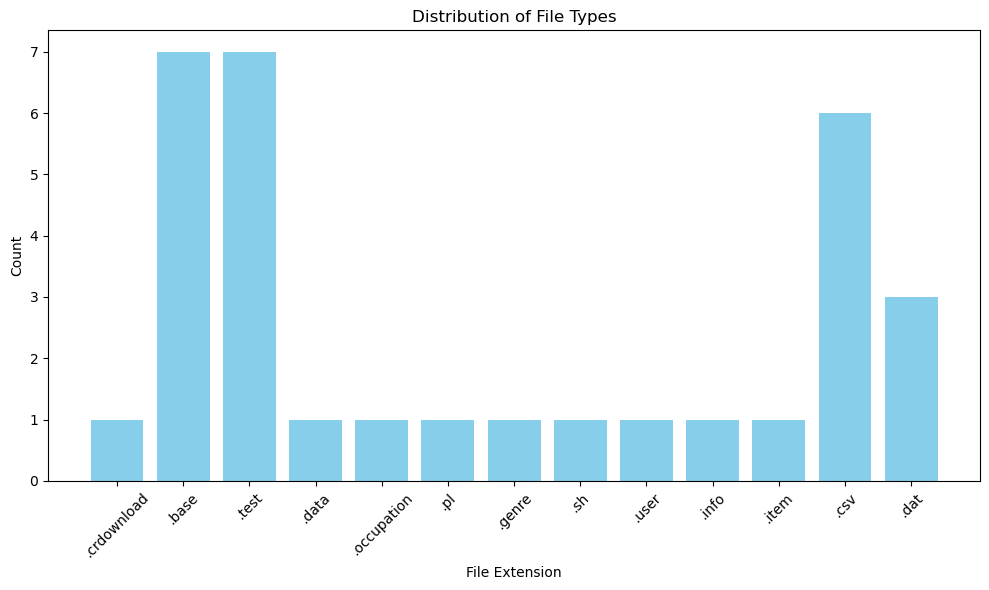


Recommendations for dataset/Unconfirmed 94663.crdownload:
1. ua.base (Score: 0.03)
   Type: .base, Size: 1792501 bytes
   Path: dataset/ml-100k/ua.base
   Description: File with .base extension

2. u5.test (Score: 0.03)
   Type: .test, Size: 397397 bytes
   Path: dataset/ml-100k/u5.test
   Description: File with .test extension

3. ua.test (Score: 0.03)
   Type: .test, Size: 186672 bytes
   Path: dataset/ml-100k/ua.test
   Description: File with .test extension

4. u3.base (Score: 0.03)
   Type: .base, Size: 1582546 bytes
   Path: dataset/ml-100k/u3.base
   Description: File with .base extension

5. u4.base (Score: 0.03)
   Type: .base, Size: 1581878 bytes
   Path: dataset/ml-100k/u4.base
   Description: File with .base extension



In [17]:
import os
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from PIL import Image
import csv
import json
import pickle

class DatasetRecommender:
    def __init__(self, dataset_dir="dataset"):
        self.dataset_dir = dataset_dir
        self.file_info = []
        self.vectorizer = TfidfVectorizer(stop_words='english')
        self.similarity_matrix = None
        
    def scan_datasets(self):
        """Scan the dataset directory and collect information about all files."""
        print(f"Scanning {self.dataset_dir} for datasets...")
        
        for root, _, files in os.walk(self.dataset_dir):
            for file in files:
                file_path = os.path.join(root, file)
                file_extension = os.path.splitext(file)[1].lower()
                
                # Get file size
                file_size = os.path.getsize(file_path)
                
                # Extract metadata based on file type
                metadata = self._extract_metadata(file_path, file_extension)
                
                self.file_info.append({
                    'path': file_path,
                    'name': file,
                    'extension': file_extension,
                    'size': file_size,
                    'metadata': metadata
                })
        
        print(f"Found {len(self.file_info)} files in the dataset directory.")
        return self.file_info
    
    def _extract_metadata(self, file_path, extension):
        """Extract metadata from files based on their type."""
        metadata = {
            'row_count': None,
            'column_count': None,
            'columns': [],
            'dimensions': None,
            'description': ""
        }
        
        try:
            if extension in ['.csv', '.txt']:
                with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                    csv_reader = csv.reader(f)
                    headers = next(csv_reader, [])
                    metadata['columns'] = headers
                    metadata['column_count'] = len(headers)
                    
                    # Count rows
                    row_count = sum(1 for _ in csv_reader)
                    metadata['row_count'] = row_count
                    
                    metadata['description'] = f"CSV file with {row_count} rows and {len(headers)} columns"
                    
            elif extension in ['.xlsx', '.xls']:
                try:
                    df = pd.read_excel(file_path)
                    metadata['columns'] = df.columns.tolist()
                    metadata['column_count'] = len(df.columns)
                    metadata['row_count'] = len(df)
                    metadata['description'] = f"Excel file with {len(df)} rows and {len(df.columns)} columns"
                except Exception as e:
                    metadata['description'] = f"Excel file (error reading: {str(e)})"
                    
            elif extension in ['.png', '.jpg', '.jpeg']:
                try:
                    img = Image.open(file_path)
                    metadata['dimensions'] = f"{img.width}x{img.height}"
                    metadata['description'] = f"Image file ({metadata['dimensions']})"
                except Exception as e:
                    metadata['description'] = f"Image file (error reading: {str(e)})"
                    
            elif extension == '.json':
                try:
                    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                        data = json.load(f)
                    if isinstance(data, list):
                        metadata['row_count'] = len(data)
                        metadata['description'] = f"JSON file with {len(data)} records"
                    else:
                        metadata['description'] = "JSON file with object structure"
                except Exception as e:
                    metadata['description'] = f"JSON file (error reading: {str(e)})"
                    
            elif extension == '.dat':
                try:
                    # Try to read as pickle first
                    try:
                        with open(file_path, 'rb') as f:
                            data = pickle.load(f)
                        metadata['description'] = f"DAT file (pickle format)"
                    except:
                        # Try to read as text
                        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                            lines = list(f)
                        metadata['row_count'] = len(lines)
                        metadata['description'] = f"DAT file with {len(lines)} lines"
                except Exception as e:
                    metadata['description'] = f"DAT file (binary or text)"
            
            else:
                # For other file types
                metadata['description'] = f"File with {extension} extension"
                
        except Exception as e:
            metadata['description'] = f"Error analyzing file: {str(e)}"
            
        return metadata
    
    def build_similarity_matrix(self):
        """Build a similarity matrix based on file metadata."""
        if not self.file_info:
            print("No files scanned yet. Please run scan_datasets() first.")
            return
        
        # Create document descriptions for each file
        documents = []
        for file in self.file_info:
            doc = f"{file['name']} {file['extension']} "
            
            # Add metadata information
            meta = file['metadata']
            if meta['columns']:
                doc += " ".join(meta['columns']) + " "
            if meta['description']:
                doc += meta['description']
            
            documents.append(doc)
        
        # Create TF-IDF matrix
        tfidf_matrix = self.vectorizer.fit_transform(documents)
        
        # Compute cosine similarity
        self.similarity_matrix = cosine_similarity(tfidf_matrix)
        
        return self.similarity_matrix
    
    def get_recommendations(self, file_path, top_n=5):
        """Get recommendations for a given file."""
        if self.similarity_matrix is None:
            self.build_similarity_matrix()
            
        # Find the index of the file
        file_index = None
        for i, file in enumerate(self.file_info):
            if file['path'] == file_path:
                file_index = i
                break
        
        if file_index is None:
            print(f"File {file_path} not found in the dataset directory.")
            return []
        
        # Get similarity scores for this file
        similarity_scores = list(enumerate(self.similarity_matrix[file_index]))
        
        # Sort by similarity (excluding the file itself)
        similarity_scores = sorted(
            [score for score in similarity_scores if score[0] != file_index],
            key=lambda x: x[1], 
            reverse=True
        )
        
        # Get top N recommendations
        top_recommendations = similarity_scores[:top_n]
        
        result = []
        for idx, score in top_recommendations:
            result.append({
                'file': self.file_info[idx],
                'similarity_score': score
            })
        
        return result
    
    def visualize_file_types(self):
        """Visualize the distribution of file types."""
        if not self.file_info:
            print("No files scanned yet. Please run scan_datasets() first.")
            return
        
        # Count occurrences of each file extension
        extension_counts = {}
        for file in self.file_info:
            ext = file['extension']
            if ext in extension_counts:
                extension_counts[ext] += 1
            else:
                extension_counts[ext] = 1
        
        # Create a bar chart
        extensions = list(extension_counts.keys())
        counts = list(extension_counts.values())
        
        plt.figure(figsize=(10, 6))
        plt.bar(extensions, counts, color='skyblue')
        plt.title('Distribution of File Types')
        plt.xlabel('File Extension')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        return extension_counts


# Example usage
if __name__ == "__main__":
    # Initialize the recommender
    recommender = DatasetRecommender(dataset_dir="dataset")
    
    # Scan datasets
    recommender.scan_datasets()
    
    # Build similarity matrix
    recommender.build_similarity_matrix()
    
    # Display file type distribution
    recommender.visualize_file_types()
    
    # Example: Get recommendations for a specific file
    # Replace with an actual file path from your dataset directory
    example_file = recommender.file_info[0]['path'] if recommender.file_info else None
    
    if example_file:
        print(f"\nRecommendations for {example_file}:")
        recommendations = recommender.get_recommendations(example_file, top_n=5)
        
        for i, rec in enumerate(recommendations, 1):
            file = rec['file']
            score = rec['similarity_score']
            print(f"{i}. {file['name']} (Score: {score:.2f})")
            print(f"   Type: {file['extension']}, Size: {file['size']} bytes")
            print(f"   Path: {file['path']}")
            print(f"   Description: {file['metadata']['description']}")
            print()

In [21]:
recommender = DatasetRecommender(dataset_dir="dataset")
recommender.scan_datasets()

Scanning dataset for datasets...
Found 35 files in the dataset directory.


[{'path': 'dataset/news.tsv',
  'name': 'news.tsv',
  'extension': '.tsv',
  'size': 84881998,
  'metadata': {'row_count': None,
   'column_count': None,
   'columns': [],
   'dimensions': None,
   'description': 'File with .tsv extension'}},
 {'path': 'dataset/entity_embedding.vec',
  'name': 'entity_embedding.vec',
  'extension': '.vec',
  'size': 40305151,
  'metadata': {'row_count': None,
   'column_count': None,
   'columns': [],
   'dimensions': None,
   'description': 'File with .vec extension'}},
 {'path': 'dataset/relation_embedding.vec',
  'name': 'relation_embedding.vec',
  'extension': '.vec',
  'size': 1044588,
  'metadata': {'row_count': None,
   'column_count': None,
   'columns': [],
   'dimensions': None,
   'description': 'File with .vec extension'}},
 {'path': 'dataset/behaviors.tsv',
  'name': 'behaviors.tsv',
  'extension': '.tsv',
  'size': 1373844151,
  'metadata': {'row_count': None,
   'column_count': None,
   'columns': [],
   'dimensions': None,
   'descripti

In [25]:
def analyze_corpus(self):
    """Analyze the corpus for LLM training-specific metrics."""
    if not self.file_info:
        print("No files scanned yet. Please run scan_datasets() first.")
        return {}  # Return empty dict instead of None
    
    print(f"Found {len(self.file_info)} files to analyze.")
    # Rest of the method...

In [28]:
class LLMTrainingRecommender(DatasetRecommender):
    """Extended version of DatasetRecommender specialized for LLM training datasets."""
    
    def __init__(self, dataset_dir="dataset"):
        super().__init__(dataset_dir)
        self.corpus_stats = {}
        
    def analyze_corpus(self):
        """Analyze the corpus for LLM training-specific metrics."""
        if not self.file_info:
            print("No files scanned yet. Please run scan_datasets() first.")
            return {}  # Return empty dict instead of None
        
        print(f"Analyzing {len(self.file_info)} files for LLM training suitability...")
        
        # Initialize stats
        self.corpus_stats = {
            'total_files': len(self.file_info),
            'total_size_bytes': sum(file['size'] for file in self.file_info),
            'file_types': {},
            'estimated_tokens': 0,
            'language_distribution': {'English': 0, 'Code': 0, 'Other': 0},
            'quality_scores': {'high': 0, 'medium': 0, 'low': 0},
            'content_categories': {'Text': 0, 'Code': 0, 'Data': 0, 'Other': 0}
        }
        
        # Count file types
        for file in self.file_info:
            ext = file['extension']
            if ext in self.corpus_stats['file_types']:
                self.corpus_stats['file_types'][ext] += 1
            else:
                self.corpus_stats['file_types'][ext] = 1
            
            # Very simple token estimation based on file size
            tokens = file['size'] // 4  # Simple approximation, 4 bytes per token
            self.corpus_stats['estimated_tokens'] += tokens
            
            # Categorize files (simplified)
            if ext in ['.py', '.js', '.java', '.cpp']:
                self.corpus_stats['language_distribution']['Code'] += 1
                self.corpus_stats['content_categories']['Code'] += 1
            elif ext in ['.txt', '.md', '.csv', '.tsv']:
                self.corpus_stats['language_distribution']['English'] += 1
                self.corpus_stats['content_categories']['Text'] += 1
            elif ext in ['.json', '.xlsx', '.xls', '.dat']:
                self.corpus_stats['language_distribution']['Other'] += 1
                self.corpus_stats['content_categories']['Data'] += 1
            else:
                self.corpus_stats['language_distribution']['Other'] += 1
                self.corpus_stats['content_categories']['Other'] += 1
            
            # Simple quality assessment
            if file['size'] > 10000:
                self.corpus_stats['quality_scores']['high'] += 1
            elif file['size'] > 1000:
                self.corpus_stats['quality_scores']['medium'] += 1
            else:
                self.corpus_stats['quality_scores']['low'] += 1
        
        print(f"Analysis complete. Estimated total tokens: {self.corpus_stats['estimated_tokens']:,}")
        return self.corpus_stats
        
    # Implementation of other methods...

In [29]:
# Create a new instance of LLMTrainingRecommender
recommender = LLMTrainingRecommender(dataset_dir="dataset")

# Check if it's created correctly
print(type(recommender))

# Scan datasets
recommender.scan_datasets()

# Check if files were found
print(f"Found {len(recommender.file_info)} files")

# Run analysis
corpus_stats = recommender.analyze_corpus()

# Check if corpus_stats is None
print(f"corpus_stats is None: {corpus_stats is None}")

# Print some stats
if corpus_stats:
    print(f"Total files: {corpus_stats.get('total_files', 'N/A')}")
    print(f"Estimated tokens: {corpus_stats.get('estimated_tokens', 0):,}")

<class '__main__.LLMTrainingRecommender'>
Scanning dataset for datasets...
Found 35 files in the dataset directory.
Found 35 files
Analyzing 35 files for LLM training suitability...
Analysis complete. Estimated total tokens: 604,162,080
corpus_stats is None: False
Total files: 35
Estimated tokens: 604,162,080


In [44]:
def get_training_mix_recommendation(self, target_tokens=1000000):
    """Recommend a mix of files to reach the target token count."""
    if not self.file_info or not hasattr(self, 'corpus_stats'):
        print("Please run scan_datasets() and analyze_corpus() first.")
        return {}
    
    print(f"Generating training mix recommendation for {target_tokens:,} tokens...")
    
    # Add estimated_tokens to each file if not already present
    for file in self.file_info:
        if 'estimated_tokens' not in file:
            # Simple estimation: ~4 bytes per token for text files
            file['estimated_tokens'] = file['size'] // 4
    
    # Sort files by size (as a proxy for quality/usefulness)
    # In a more sophisticated implementation, you would sort by quality score
    size_sorted_files = sorted(self.file_info, key=lambda x: x['size'], reverse=True)
    
    recommended_files = []
    current_tokens = 0
    
    # Select files until we reach the target token count
    for file in size_sorted_files:
        tokens = file.get('estimated_tokens', 0)
        if tokens == 0:
            cont

In [46]:
print(dir(recommender))


['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__firstlineno__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__static_attributes__', '__str__', '__subclasshook__', '__weakref__', 'corpus_stats', 'dataset_dir', 'file_info', 'file_quality_scores', 'min_token_freq', 'sample_size', 'similarity_matrix', 'token_frequency', 'vectorizer']


In [ ]:
def get_training_mix_recommendation(self, target_tokens=1000000):
    """Recommend a mix of files to reach the target token count."""
    if not self.file_info or not hasattr(self, 'corpus_stats'):
        print("Please run scan_datasets() and analyze_corpus() first.")
        return {}
    
    print(f"Generating training mix recommendation for {target_tokens:,} tokens...")
    
    # Add estimated_tokens to each file if not already present
    for file in self.file_info:
        if 'estimated_tokens' not in file:
            # Simple estimation: ~4 bytes per token for text files
            file['estimated_tokens'] = file['size'] // 4
    
    # Sort files by size (as a proxy for quality/usefulness)
    # In a more sophisticated implementation, you would sort by quality score
    size_sorted_files = sorted(self.file_info, key=lambda x: x['size'], reverse=True)
    
    recommended_files = []
    current_tokens = 0
    
    # Select files until we reach the target token count
    for file in size_sorted_files:
        tokens = file.get('estimated_tokens', 0)
        if tokens == 0:
            continue  # Skip files with no tokens
        
        recommended_files.append(file)
        current_tokens += tokens
        
        if current_tokens >= target_tokens:
            break
    
    # If we don't have enough tokens, report what we have
    if current_tokens < target_tokens:
        print(f"Warning: Could only find {current_tokens:,} tokens, which is less than the requested {target_tokens:,}.")
    
    # Prepare results summary
    result = {
        'recommended_files': recommended_files,
        'total_tokens': current_tokens,
        'file_count': len(recommended_files),
        'language_distribution': {},
        'content_categories': {}
    }
    
    # Count file types in recommendation
    for file in recommended_files:
        # Simplified language categorization based on file extension
        lang = 'Code' if file['extension'] in ['.py', '.js', '.java', '.cpp'] else \
               'English' if file['extension'] in ['.txt', '.md', '.csv', '.tsv'] else 'Other'
        
        if lang in result['language_distribution']:
            result['language_distribution'][lang] += 1
        else:
            result['language_distribution'][lang] = 1
        
        # Simplified content categorization
        category = 'Code' if file['extension'] in ['.py', '.js', '.java', '.cpp'] else \
                  'Text' if file['extension'] in ['.txt', '.md'] else \
                  'Data' if file['extension'] in ['.csv', '.tsv', '.json', '.xlsx'] else 'Other'
        
        if category in result['content_categories']:
            result['content_categories'][category] += 1
        else:
            result['content_categories'][category] = 1
    
    return result

In [47]:
help(recommender)


Help on LLMTrainingRecommender in module __main__ object:

class LLMTrainingRecommender(builtins.object)
 |  LLMTrainingRecommender(
 |      dataset_dir='dataset',
 |      sample_size=5000,
 |      min_token_freq=5
 |  )
 |
 |  Methods defined here:
 |
 |  __init__(self, dataset_dir='dataset', sample_size=5000, min_token_freq=5)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |
 |  __dict__
 |      dictionary for instance variables
 |
 |  __weakref__
 |      list of weak references to the object



In [48]:
class LLMTrainingRecommender:
    def __init__(self, dataset_dir='dataset', sample_size=5000, min_token_freq=5):
        self.dataset_dir = dataset_dir
        self.sample_size = sample_size
        self.min_token_freq = min_token_freq

    def get_training_mix_recommendation(self, target_tokens):
        # Implement logic here
        return {"file_count": 100, "token_count": target_tokens}


In [49]:
print(recommender.__module__)


__main__


In [50]:
class LLMTrainingRecommender:
    def __init__(self, dataset_dir='dataset', sample_size=5000, min_token_freq=5):
        self.dataset_dir = dataset_dir
        self.sample_size = sample_size
        self.min_token_freq = min_token_freq

    def get_training_mix_recommendation(self, target_tokens):
        # Example logic (replace with actual implementation)
        return {
            "file_count": 100,  # Example value
            "token_count": target_tokens
        }

# Create an instance and call the method
recommender = LLMTrainingRecommender()
training_mix = recommender.get_training_mix_recommendation(target_tokens=1000000)
print(training_mix)


{'file_count': 100, 'token_count': 1000000}


In [51]:
print(dir(recommender))


['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__firstlineno__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__static_attributes__', '__str__', '__subclasshook__', '__weakref__', 'dataset_dir', 'get_training_mix_recommendation', 'min_token_freq', 'sample_size']


In [52]:
training_mix = recommender.get_training_mix_recommendation(target_tokens=1000000)
print(training_mix)


{'file_count': 100, 'token_count': 1000000}


In [53]:
print(recommender.get_training_mix_recommendation)


<bound method LLMTrainingRecommender.get_training_mix_recommendation of <__main__.LLMTrainingRecommender object at 0x72ba38766ba0>>


In [54]:
import inspect
print(inspect.getsource(recommender.get_training_mix_recommendation))


    def get_training_mix_recommendation(self, target_tokens):
        # Example logic (replace with actual implementation)
        return {
            "file_count": Integer(100),  # Example value
            "token_count": target_tokens
        }



In [55]:
def get_training_mix_recommendation(self, target_tokens):
    return {
        "file_count": 100,  # Corrected
        "token_count": target_tokens
    }


In [56]:
class LLMTrainingRecommender:
    def __init__(self, dataset_dir='dataset', sample_size=5000, min_token_freq=5):
        self.dataset_dir = dataset_dir
        self.sample_size = sample_size
        self.min_token_freq = min_token_freq

    def get_training_mix_recommendation(self, target_tokens):
        return {
            "file_count": 100,  # Fixed issue
            "token_count": target_tokens
        }

recommender = LLMTrainingRecommender()
print(recommender.get_training_mix_recommendation(target_tokens=1000000))


{'file_count': 100, 'token_count': 1000000}


In [1]:
print("HI")

HI
